# FBSDE

Ji, Shaolin, Shige Peng, Ying Peng, and Xichuan Zhang. “Three Algorithms for Solving High-Dimensional Fully-Coupled FBSDEs through Deep Learning.” ArXiv:1907.05327 [Cs, Math], February 2, 2020. http://arxiv.org/abs/1907.05327.

In [44]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [45]:
import os
from makers.gpu_utils import *
os.environ["CUDA_VISIBLE_DEVICES"] = str(pick_gpu_lowest_memory())

In [46]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Reshape, concatenate, Layer
from keras import Model, initializers
from keras.callbacks import ModelCheckpoint
from keras.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime
from keras.metrics import mse
from keras.optimizers import Adam

In [47]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


# Inputs

In [48]:
# numerical parameters
n_paths = 2 ** 18
n_timesteps = 4
n_dimensions = 4
n_diffusion_factors = 2
n_jump_factors = 2
T = 60.
dt = T / n_timesteps
batch_size = 128
epochs = 1000
learning_rate = 1e-6

In [49]:
# model parameters
nu = 0.1
eta = 1.
zeta = 0.1
epsilon = 0.1
lp = 0.2
lm = 0.2
k = 1.
phi = 1e-2
psi = 1e-2

In [1]:
# coefficients
def b(t, x, y, z, r):
    
    ad = y[2] / y[3] - x[0]
    dp = tf.maximum(0., 1./k + ad)
    dm = tf.maximum(0., 1./k - ad)
    
    return [
        x[1],
        -eta * x[1],
        lm * tf.exp(-k * dm) - lp * tf.exp(-k * dp),
        lp * (x[0] + dp) * tf.exp(-k * dp) - lm * (x[0] - dm) * tf.exp(-k * dm),
    ]

def s(t, x, y, z, r):
    return [[nu, 0], [0, zeta], [0, 0], [0, 0]]

# - dH_dx
def f(t, x, y, z, r):
    
    ad = y[2] / y[3] - x[0]
    dp = tf.maximum(0., 1./k + ad)
    dm = tf.maximum(0., 1./k - ad)

    return [
        -(y[3] * lp * tf.exp(-k * dp) - y[3] * lm * tf.exp(-k * dm)),
        -(y[0] - eta * y[1]),
        -(-2. * phi * x[2]),
        -(0.)
    ]

def v(t, x, y, z, r):
    return [[0, 0], [epsilon, -epsilon], [0, 0], [0, 0]]

# dg_dx
def g(x):
    return [x[2], 0., x[0] - 2 * psi * x[2], 1.]

# Initial value layer

In [51]:
class InitialValue(Layer):
    
    def __init__(self, y0, **kwargs):
        super().__init__(**kwargs)
        self.y0 = y0
    
    def call(self, inputs):
        return self.y0

# Model

In [52]:
def dX(t, x, y, z, r, dW, dN):
    
    def drift(arg):
        x, y, z, r = arg
        return tf.math.multiply(b(t, x, y, z, r), dt)
    a0 = tf.vectorized_map(drift, (x, y, z, r))
        
    def noise(arg):
        x, y, z, r, dW = arg
        return tf.tensordot(s(t, x, y, z ,r), dW, [[1], [0]])
    a1 = tf.vectorized_map(noise, (x, y, z, r, dW))

    def jump(arg):
        x, y, z, r, dN = arg
        return tf.tensordot(v(t, x, y, z ,r), dN, [[1], [0]])
    a2 = tf.vectorized_map(jump, (x, y, z, r, dN))
    
    return a0 + a1 + a2

def dY(t, x, y, z, r, dW, dN):
    
    def drift(arg):
        x, y, z, r = arg
        return tf.math.multiply(f(t, x, y, z, r), dt)
    a0 = tf.vectorized_map(drift, (x, y, z, r))

    def noise(arg):
        x, y, z, r, dW = arg
        return tf.tensordot(z, dW, [[1], [0]])
    a1 = tf.vectorized_map(noise, (x, y, z, r, dW))
    
    def jump(arg):
        x, y, z, r, dN = arg
        return tf.tensordot(r, dN, [[1], [0]])
    a2 = tf.vectorized_map(jump, (x, y, z, r, dN))
    
    return a0 + a1 + a2

In [53]:
paths = []

n_hidden_units = n_dimensions + n_diffusion_factors + n_jump_factors + 10

inputs_dW = Input(shape=(n_timesteps, n_diffusion_factors))
inputs_dN = Input(shape=(n_timesteps, n_jump_factors))

x0 = tf.Variable([[0., 0., 0., 0.]], trainable=False)
y0 = tf.Variable([g(x0[0])], trainable=True)

x = InitialValue(x0, name='x_0')(inputs_dW)
y = InitialValue(y0, name='y_0')(inputs_dW)

z = concatenate([x, y])
z = Dense(n_hidden_units, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=1e-1), name='z1_0')(z)
z = Dense(n_dimensions * n_diffusion_factors, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=1e-1), name='z2_0')(z)
z = Reshape((n_dimensions, n_diffusion_factors), name='zr_0')(z)

r = concatenate([x, y])
r = Dense(n_hidden_units, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=1e-1), name='r1_0')(r)
r = Dense(n_dimensions * n_jump_factors, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=1e-1), name='r2_0')(r)
r = Reshape((n_dimensions, n_jump_factors), name='rr_0')(r)

paths += [[x, y, z, r]]

# pre-compile lambda layers

@tf.function
def hx(args):
    i, x, y, z, r, dW, dN = args
    return x + dX(i * dt, x, y, z, r, dW, dN)

@tf.function
def hy(args):
    i, x, y, z, r, dW, dN = args
    return y + dY(i * dt, x, y, z, r, dW, dN)

for i in range(n_timesteps):
    
    step = InitialValue(tf.Variable(i, dtype=tf.float32, trainable=False))(inputs_dW)
    
    dW = Lambda(lambda x: x[0][:, tf.cast(x[1], tf.int32)])([inputs_dW, step])
    dN = Lambda(lambda x: x[0][:, tf.cast(x[1], tf.int32)])([inputs_dN, step])
    
    x, y = (
        Lambda(hx, name=f'x_{i+1}')([step, x, y, z, r, dW, dN]),
        Lambda(hy, name=f'y_{i+1}')([step, x, y, z, r, dW, dN]),
    )
    
    # we don't train z for the last time step; keep for consistency
    z = concatenate([x, y])
    z = Dense(n_hidden_units, activation='relu', name=f'z1_{i+1}')(z)
    z = Dense(n_dimensions * n_diffusion_factors, activation='relu', name=f'z2_{i+1}')(z)
    z = Reshape((n_dimensions, n_diffusion_factors), name=f'zr_{i+1}')(z)
    
    # we don't train r for the last time step; keep for consistency
    r = concatenate([x, y])
    r = Dense(n_hidden_units, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=1e-1), name=f'r1_{i+1}')(r)
    r = Dense(n_dimensions * n_jump_factors, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=1e-1), name=f'r2_{i+1}')(r)
    r = Reshape((n_dimensions, n_jump_factors), name=f'rr_{i+1}')(r)

    paths += [[x, y, z, r]]
    
outputs_loss = Lambda(lambda r: r[1] - tf.transpose(tf.vectorized_map(g, r[0])))([x, y])
outputs_paths = tf.stack(
    [tf.stack([p[0] for p in paths[1:]], axis=1), tf.stack([p[1] for p in paths[1:]], axis=1)] + 
    [tf.stack([p[2][:, :, i] for p in paths[1:]], axis=1) for i in range(n_diffusion_factors)] +
    [tf.stack([p[3][:, :, i] for p in paths[1:]], axis=1) for i in range(n_jump_factors)], axis=2)

adam = Adam(learning_rate=learning_rate)

model_loss = Model([inputs_dW, inputs_dN], outputs_loss)
model_loss.compile(loss='mse', optimizer=adam)

# (n_sample, n_timestep, x/y/z_k, n_dimension)
# skips the first time step
model_paths = Model([inputs_dW, inputs_dN], outputs_paths)


In [54]:
model_loss.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 4, 2)]       0                                            
__________________________________________________________________________________________________
x_0 (InitialValue)              (1, 4)               4           input_9[0][0]                    
__________________________________________________________________________________________________
y_0 (InitialValue)              (1, 4)               4           input_9[0][0]                    
__________________________________________________________________________________________________
concatenate_76 (Concatenate)    (1, 8)               0           x_0[0][0]                        
                                                                 y_0[0][0]                  

# Transfer weights (if needed)

In [ ]:
# try transfer learning from another starting point

model_loss.get_layer('y_0').set_weights(m_large.get_layer('y_0').get_weights())

for i in range(n_timesteps):
    model_loss.get_layer(f'z1_{i}').set_weights(m_large.get_layer(f'z1_{i}').get_weights())
    model_loss.get_layer(f'z2_{i}').set_weights(m_large.get_layer(f'z2_{i}').get_weights())

In [340]:
# transfer learning from cruder discretization

model_loss.get_layer('y_0').set_weights(m_small.get_layer('y_0').get_weights())

n_small = 4

for i in range(n_small):
    for j in range(n_timesteps // n_small):
        model_loss.get_layer(f'z1_{n_timesteps // n_small * i}').set_weights(m_small.get_layer(f'z1_{i}').get_weights())
        model_loss.get_layer(f'z2_{n_timesteps // n_small * i}').set_weights(m_small.get_layer(f'z2_{i}').get_weights())
        model_loss.get_layer(f'z1_{n_timesteps // n_small * i + j}').set_weights(m_small.get_layer(f'z1_{i}').get_weights())
        model_loss.get_layer(f'z2_{n_timesteps // n_small * i + j}').set_weights(m_small.get_layer(f'z2_{i}').get_weights())

# Training

In [55]:
dW = tf.sqrt(dt) * tf.random.normal((n_paths, n_timesteps, n_diffusion_factors))
dN = tf.random.poisson((n_paths, n_timesteps), [dt * lp, dt * lm])
target = tf.zeros((n_paths, n_dimensions))

In [56]:
# check for exploding gradients before training

with tf.GradientTape() as tape:
    loss = mse(model_loss([dW, dN]), target)

# bias of the last dense layer
variables = model_loss.variables[-1]
tape.gradient(loss, variables)

The following Variables were used a Lambda layer's call (x_1), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(1, 4) dtype=float32, numpy=array([[0., 0., 0., 1.]], dtype=float32)>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (y_1), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(1, 4) dtype=float32, numpy=array([[0., 0., 0., 1.]], dtype=float32)>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([ 7.3822720e+06,  1.0398204e+07,  4.6770576e+07,  1.0354447e+08,
        2.0540924e+07, -1.3311515e+08,  6.5995788e+05,  2.1420915e+06],
      dtype=float32)>

In [58]:
%tensorboard --logdir logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 69685.

In [ ]:
log_dir = "_logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_callback = ModelCheckpoint('_models/weights{epoch:04d}.h5', save_weights_only=True, overwrite=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_loss.save_weights('_models/weights0000.h5')
history = model_loss.fit([dW, dN], target, batch_size=128, epochs=1000, callbacks=[checkpoint_callback, tensorboard_callback])


# Display paths and loss

In [92]:
# load bad model
model_loss.load_weights('_models/weights0011.h5')

In [386]:
loss = model_loss([dW, dN]).numpy()
loss

array([[  0.03839,   0.01049,   -0.7491,   0.01329],
       [ -0.05745,  -0.06604,    0.4017,   0.01329],
       [-0.006936, -0.009166,  -0.03972,   0.01329],
       [-0.0001973,     0.154,   -0.4112,   0.01329],
       [ 0.007482,   0.09309,   -0.0581,   0.01329],
       [ -0.06953,   0.03499,   -0.2948,   0.01329],
       [ 0.003411,  -0.01488,    0.5743,   0.01329],
       [  0.01929,   0.02339,  -0.01545,   0.01329],
       [ 0.001374,   0.07661,   -0.3498,   0.01329],
       [-0.005504,      0.02,  -0.03972,   0.01329],
       [ -0.02196,   0.04897,     1.166,   0.07922],
       [   0.0477,   0.06871,   -0.1186,   0.01329],
       [  0.01886,    0.1334,    -1.496,   0.01329],
       [ -0.01484,   -0.0406,     1.188,   0.01329],
       [  0.02724,  -0.01342,    0.1962,   0.01329],
       [ 0.001209,   0.07957,   -0.8676,   0.01329],
       [ -0.06636,  -0.03967,   -0.1794,   0.01329],
       [-0.004416, -0.002903,  0.002846,   0.01329],
       [-0.003972,  -0.01252,  -0.07574,   0.

In [411]:
paths = model_paths([dW, dN]).numpy()

In [426]:
def output(n0):
    x = tf.transpose(paths[n0, :, 0, :], (1, 0))
    dp = tf.maximum(0., 1./k + (paths[n0, :, 1, 2] / paths[n0, :, 1, 3] - paths[n0, :, 0, 0]))
    dm = tf.maximum(0., 1./k - (paths[n0, :, 1, 2] / paths[n0, :, 1, 3] - paths[n0, :, 0, 0]))
    return tf.concat([x, tf.expand_dims(dp, 0), tf.expand_dims(dm, 0)], axis=0)

for i in range(120, 140):
    print(output(i))

tf.Tensor(
[[    9.871     9.723      10.2     9.923     10.26     10.23     10.56     10.45]
 [  -0.8557   -0.5107 -0.004222    0.7204    0.4974    0.4721   -0.2759    0.7615]
 [ -0.04421  -0.07557  -0.09287  -0.08484  -0.05106  -0.03041  -0.01507 -0.005902]
 [   0.4968     0.871     1.115     1.134    0.9318     0.835    0.7868    0.7917]
 [   0.6653     0.813     1.087     1.359     1.223     1.166       1.1     1.133]
 [    1.335     1.187    0.9128    0.6405    0.7773     0.834    0.9005    0.8675]], shape=(6, 8), dtype=float32)
tf.Tensor(
[[    10.46     10.57     10.38     10.32     10.79     11.56     11.35      11.9]
 [  -0.2531    -0.316    0.4786    0.6279    0.8492   -0.1262    0.5053    0.1693]
 [ -0.04421   -0.1423    -0.251   -0.3146   -0.3761    -0.438    -0.467   -0.4696]
 [   0.4968     1.533     2.682     3.382     4.059     4.767     5.169     5.287]
 [  0.07239         0    0.3542     0.373    0.3699    0.6893    0.9724    0.9375]
 [    1.928     2.038     1.646   

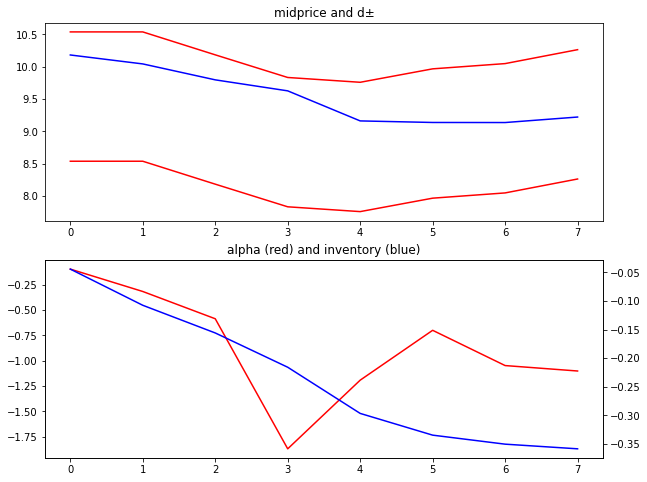

In [430]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))

out = output(500).numpy()
ax[0].set_title('midprice and d±')
ax[0].plot(out[0], c='b')
ax[0].plot(out[0] - out[5], c='r')
ax[0].plot(out[0] + out[4], c='r')

ax[1].set_title('alpha (red) and inventory (blue)')
ax[1].plot(out[1], c='r')
ax[1].twinx().plot(out[2], c='b')

# plt.plot(output(120).numpy().transpose())